In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

In [4]:
data_frame = pd.read_excel("dataset/insurance_claims_data.xlsx")

data_frame.head()
data_frame.columns
print(len(data_frame.columns))

39


In [5]:
data_frame.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


Now that we have looked at the meta data. Let's clean this data and encode it to make it suitable for training a DecisionTreeClassifier.
My approach to normalize this data is:
- Drop all null valued data points.
- Convert features with type of timestamp into a meaning full categorical feature.
- Encode every categorical feature to make it Training ready.
- Reduce the variance for features to the maximum extend possible.

In [6]:
#Let's begin with removing all the rows that have null/no values in them
data_frame = data_frame.dropna()

In [7]:
print(data_frame.describe())
#this would give us all continous features.

       months_as_customer          age  policy_number  policy_deductable  \
count         1000.000000  1000.000000    1000.000000        1000.000000   
mean           203.954000    38.948000  546238.648000        1136.000000   
std            115.113174     9.140287  257063.005276         611.864673   
min              0.000000    19.000000  100804.000000         500.000000   
25%            115.750000    32.000000  335980.250000         500.000000   
50%            199.500000    38.000000  533135.000000        1000.000000   
75%            276.250000    44.000000  759099.750000        2000.000000   
max            479.000000    64.000000  999435.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count            1000.000000    1.000000e+03    1000.000000    1000.000000   
mean             1256.406150    1.101000e+06  501214.488000   25126.100000   
std               244.167395    2.297407e+06   71701.610941   27872.187708   
min

In [8]:
#lets see which features are categorical:

categorical_features = data_frame.select_dtypes(include=['object', 'category'])
categorical_features.columns
print(len(categorical_features.columns))

19


All the columns that were returned within the variable categorical_features, are to be encoded.

Lets perfom some encoding for better fitting.

Lets use OneHotEncoder for these categorical features.

In [9]:

X = data_frame.drop(columns=["fraud_reported"])
y = data_frame["fraud_reported"]

#I will re extract the featues that should be encoded.
string_features = X.select_dtypes(include="object").columns

#converting these to strings
X[string_features] = X[string_features].astype(str)

#lets encode
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(X[string_features])

#getting feature names and encoder categories
categories = encoder.categories_
feature_names = []
for i, category in enumerate(categories):
    names = [f"{string_features[i]}_{value}" for value in category]
    feature_names.extend(names)

X_encoded = pd.DataFrame(encoded_data, columns=feature_names)

# Concatenate input features and target variable
data_encoded = pd.concat([X_encoded, y], axis=1)

# Drop rows with missing values
data_encoded = data_encoded.dropna()

I decided to choose Logistic Regression as my baseline model.
Lets fit this.


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
model = LogisticRegression()

In [11]:
X.columns = X.columns.astype(str)
X = data_encoded.drop(columns=["fraud_reported"])
print(X.head())
y = data_encoded["fraud_reported"]
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42)

   policy_state_IL  policy_state_IN  policy_state_OH  policy_csl_100/300  \
0              0.0              0.0              1.0                 0.0   
1              0.0              1.0              0.0                 0.0   
2              0.0              0.0              1.0                 1.0   
3              1.0              0.0              0.0                 0.0   
4              1.0              0.0              0.0                 0.0   

   policy_csl_250/500  policy_csl_500/1000  insured_sex_FEMALE  \
0                 1.0                  0.0                 0.0   
1                 1.0                  0.0                 0.0   
2                 0.0                  0.0                 1.0   
3                 1.0                  0.0                 1.0   
4                 0.0                  1.0                 0.0   

   insured_sex_MALE  insured_education_level_Associate  \
0               1.0                                0.0   
1               1.0           

In [12]:
model = model.fit(X_train, y_train)

In [13]:
y_pred = model.predict(X_test)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.79      0.88      0.83       220
           Y       0.52      0.36      0.43        80

    accuracy                           0.74       300
   macro avg       0.65      0.62      0.63       300
weighted avg       0.72      0.74      0.72       300



Now that we've seen these results at default threshold and params lets plot a confusion matrix


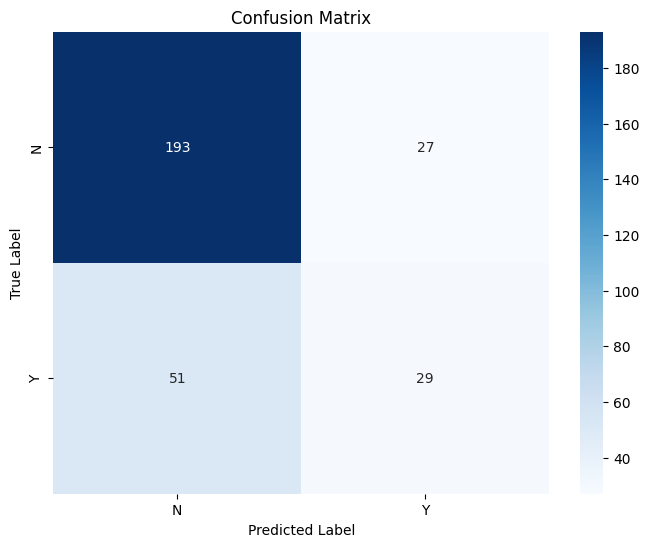

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)  # Get the unique labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)  # Compute the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and an axis object
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)  # Plot the confusion matrix as a heatmap
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')  
    ax.set_title('Confusion Matrix')  
    plt.show()  


plot_confusion_matrix(y_test, y_pred)

As we can see more than half of the actual fraud_Reported cases have been classified as not fraudulent! Which means we can now try and lower the threshold inorder to get the necessary.


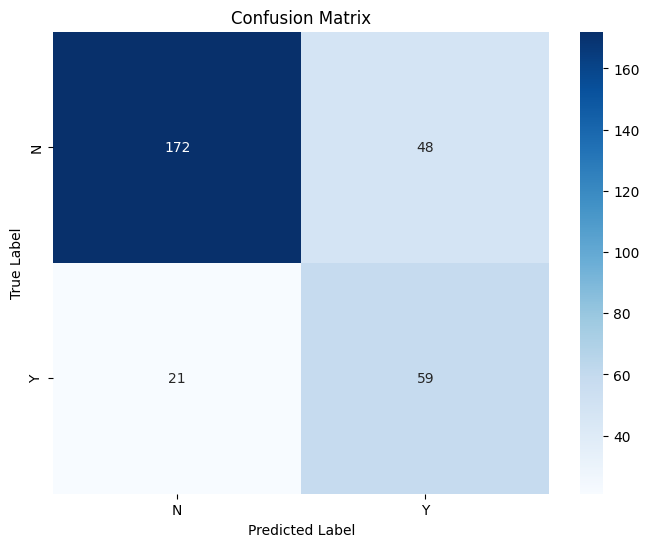

In [16]:
y_pred_proba = model.predict_proba(X_test)
y_pred_with_prob = list()
threshold = 0.2
for prediction in y_pred_proba:
    if prediction[1]>=threshold:
        y_pred_with_prob.append("Y")
    else:
        y_pred_with_prob.append("N")

plot_confusion_matrix(y_test, y_pred_with_prob)

In [17]:
print(classification_report(y_test, y_pred_with_prob))

              precision    recall  f1-score   support

           N       0.89      0.78      0.83       220
           Y       0.55      0.74      0.63        80

    accuracy                           0.77       300
   macro avg       0.72      0.76      0.73       300
weighted avg       0.80      0.77      0.78       300



In [29]:
y = y_train
y= y.replace('Y', 1)
y= y.replace('N', 0)
y_t = y_test

y_t = y_t.replace('Y', 1)
y_t = y.replace('N', 0)
print(y)
median = np.median(y)


y_pred = np.full(len(y_t), median)


mse = mean_squared_error(y_t, y_pred)

print("Mean Squared Error:"+str(mse))

541    0
440    0
482    1
422    0
778    0
      ..
106    1
270    0
860    0
435    0
102    0
Name: fraud_reported, Length: 700, dtype: int64
Mean Squared Error:0.23857142857142857


In [30]:

mean = np.mean(y)

y_pred = np.full(len(y_t), mean)

mse = mean_squared_error(y_t, y_pred)

print("Mean Squared Error:"+str(mse))

Mean Squared Error:0.1816551020408163


I am personally satisfied defining LR as my baseline model the Precision is pretty decent considering I lower the threshold to 0.3 - 0.2 which results in better accuracy as well. 

It would also be interesting to see other models perform on this set, and to figure out the best fit model.

Altough one might argue that 0.78 accuracy is pretty low compared to better precision and recall that was accuracy. The goal is to identify as many as Insurance fraud possible!